# Startup

In [1]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install pandas tqdm numpy matplotlib pyspark dask

In [2]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import re

In [3]:
#####################
# GLOBAL PARAMETERS #
#####################

chunk_size = 100000 # 10000

authors_path = r"datasets/lighter_authors.json"
books_path = r"datasets/lighter_books.json"
list_path = r"datasets/list.json"
series_path = r"datasets/series.json"

# Loading the data into Pandas' Dataframe

The dataset provided is composed of a "lighter_authors.json" file of about 0.5 Gbs and a "lighter_books.json" file of about 15 Gbs. Considering that where will be a data-type conversion the dataset will become even bigger when loaded on pandas and they could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the result.
* For every request we could extract only the columns we are interested with.

<!-- Both this approach are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset lighter by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions. -->

## Authors dataset

In [4]:
# load the dataset from the .json file to a pandas dataframe
authors = pd.read_json(authors_path, lines = True)

In [5]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [6]:
# check some infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [7]:
# check some infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                       132
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               74732848
book_ids               74732848
works_count             2814136
id                      2814136
name                   26225127
gender                 21473021
image_url              44826054
about                 410897820
fans_count              2814136
dtype: int64

In [8]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.62 GBs of RAM!
The 'about' column covers 61.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our analysis so they can be removed.

In [5]:
# remove the useless columns
authors.drop(columns = ["image_url", "about"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.2 GBs of RAM!


[TODO] CHANGE DATA TYPES?

## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by only observing some rows

In [7]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json(books_path, lines = True, nrows = 100000)

In [ ]:
# check the first lines of the chunk
books.head()

In [12]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9999 non-null   int64  
 1   title                      9999 non-null   object 
 2   authors                    3742 non-null   object 
 3   author_name                9999 non-null   object 
 4   author_id                  9999 non-null   int64  
 5   work_id                    9999 non-null   int64  
 6   isbn                       9999 non-null   object 
 7   isbn13                     9999 non-null   object 
 8   asin                       9999 non-null   object 
 9   language                   9999 non-null   object 
 10  average_rating             9999 non-null   float64
 11  rating_dist                9999 non-null   object 
 12  ratings_count              9999 non-null   int64  
 13  text_reviews_count         9999 non-null   int64

In [13]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                              79992
title                          929445
authors                        455800
author_name                    713677
author_id                       79992
work_id                         79992
isbn                           667641
isbn13                         697223
asin                           589989
language                       596758
average_rating                  79992
rating_dist                    972520
ratings_count                   79992
text_reviews_count              79992
publication_date               654329
original_publication_date      638162
format                         655109
edition_information            610372
image_url                     1484359
publisher                      710464
num_pages                      401847
series_id                      598856
series_name                    634022
series_position                588928
shelves                       5910832
description 

In [14]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.03 GBs of RAM!
The 'about' column covers 35.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us. We remove it together with other useless columns such as "image_url", "isb", "isbn13", "asin" [TODO].

In [15]:
# remove the useless columns
books.drop(columns = ["isbn", "isbn13", "asin", "edition_information", "publisher", "image_url", "description", "shelves"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.01 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [16]:
books = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
columns_to_drop = ["isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description"]

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    books = pd.concat([books, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [17]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027431 entries, 0 to 7027430
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   title                      object 
 2   authors                    object 
 3   author_name                object 
 4   author_id                  int64  
 5   work_id                    int64  
 6   language                   object 
 7   average_rating             float64
 8   rating_dist                object 
 9   ratings_count              int64  
 10  text_reviews_count         int64  
 11  publication_date           object 
 12  original_publication_date  object 
 13  format                     object 
 14  num_pages                  object 
 15  series_id                  object 
 16  series_name                object 
 17  series_position            object 
dtypes: float64(1), int64(5), object(12)
memory usage: 965.1+ MB


In [18]:
# check some infos about the RAM usage of every column
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage

Index                              132
id                            56219448
title                        684810705
authors                      266432328
author_name                  510420434
author_id                     56219448
work_id                       56219448
language                     417560422
average_rating                56219448
rating_dist                  630673989
ratings_count                 56219448
text_reviews_count            56219448
publication_date             448126622
original_publication_date    454730116
format                       447158221
num_pages                    323639741
series_id                    420869401
series_name                  445383460
series_position              413558394
dtype: int64

In [19]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")

The dataset uses 5.4 GBs of RAM!


# Research questions [RQs]

## [RQ1] Exploratory Data Analysis (EDA)

The Books dataset has some void string entries in the num_pages column.

# Analyze authors

In [8]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517670e+05,351767.000000,351767.000000,3.517670e+05,3.517670e+05,351767.000000
mean,4.770586e+03,3.651194,330.993243,2.593714e+01,7.751861e+06,111.615731
std,9.769395e+04,1.211482,3857.539191,3.066083e+03,6.578409e+06,2661.018139
min,-4.100000e+01,-31.000000,0.000000,0.000000e+00,4.000000e+00,-33.000000
25%,6.000000e+00,3.600000,1.000000,2.000000e+00,1.535315e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000e+00,6.470396e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.500000e+01,1.434041e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,1.775176e+06,2.124802e+07,766035.000000


In [6]:
l=[]
for i in range(len(authors['average_rating'])):
    if authors['average_rating'][i]<0:
        print(i)
        l.append(i)
    if authors['ratings_count'][i]<0:
        print(i) 
        l.append(i)
    if authors['fans_count'][i]<0:
        print(i)
        l.append(i)
    if authors['name'][i]=='NOT A BOOK':
        print(i)
        l.append(i)
        
l  

83322
104296
129604
253327
253327
264572
264606
264611
264638
264743
264747
264859
264876
264878
264919
265036
265152
270664
274931
274940
275034
275039
275082
282878
285757
286226
337953
338249
343284


[83322,
 104296,
 129604,
 253327,
 253327,
 264572,
 264606,
 264611,
 264638,
 264743,
 264747,
 264859,
 264876,
 264878,
 264919,
 265036,
 265152,
 270664,
 274931,
 274940,
 275034,
 275039,
 275082,
 282878,
 285757,
 286226,
 337953,
 338249,
 343284]

In [7]:
l = list(set(l))
l

[275082,
 253327,
 286226,
 264859,
 264606,
 337953,
 264611,
 264743,
 264747,
 264876,
 264878,
 264572,
 285757,
 264638,
 265152,
 129604,
 270664,
 338249,
 265036,
 264919,
 275034,
 275039,
 104296,
 274931,
 343284,
 83322,
 274940,
 282878]

In [8]:
for i in l:
    authors= authors.drop(i)
    
authors.describe()    

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517390e+05,351739.000000,351739.000000,351739.000000,3.517390e+05,351739.000000
mean,4.770636e+03,3.651282,330.992600,20.891963,7.751802e+06,111.612176
std,9.769765e+04,1.210087,3857.661276,665.406654,6.578580e+06,2661.113550
min,0.000000e+00,0.000000,0.000000,0.000000,4.000000e+00,0.000000
25%,6.000000e+00,3.600000,1.000000,2.000000,1.534885e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000,6.470275e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,15.000000,1.434084e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,186086.000000,2.124802e+07,766035.000000


now there no 'strange' values and ratings_count, average_rating and fans_count have not any outlier

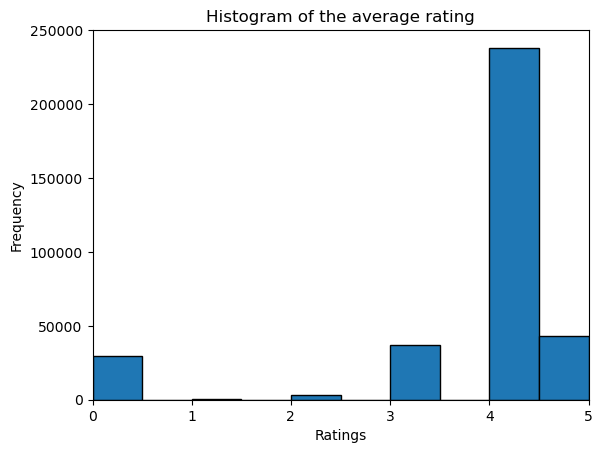

<Figure size 500x500 with 0 Axes>

In [12]:
#hist of the average ratings of all the authors
import matplotlib.pyplot as plt 
plt.hist(round(authors.average_rating), bins=10, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

As we can see there are a lot of ratings with values from 4.0 to 5.0 and only a small part with rating values from 1.0 to 3.0

In [ ]:
#plot of the works_count of all the authors
import matplotlib.pyplot as plt 
plt.bar(authors.name, authors.works_count, color='skyblue')

#plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

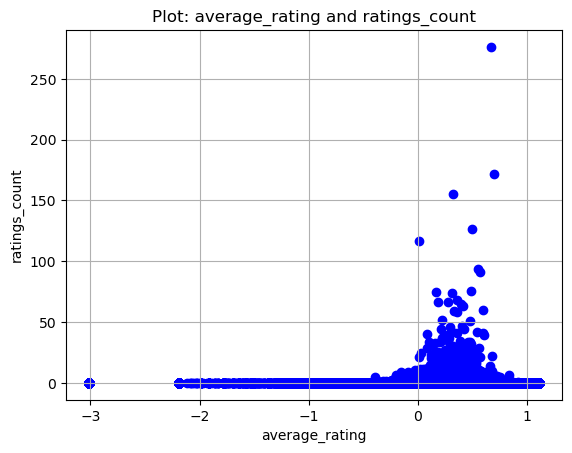

In [13]:
from sklearn.preprocessing import StandardScaler

X = authors[["average_rating"]]
Y = authors[["ratings_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='blue', marker='o')

plt.title('Plot: average_rating and ratings_count')
plt.xlabel('average_rating')
plt.ylabel('ratings_count')
plt.grid(True)


plt.show()

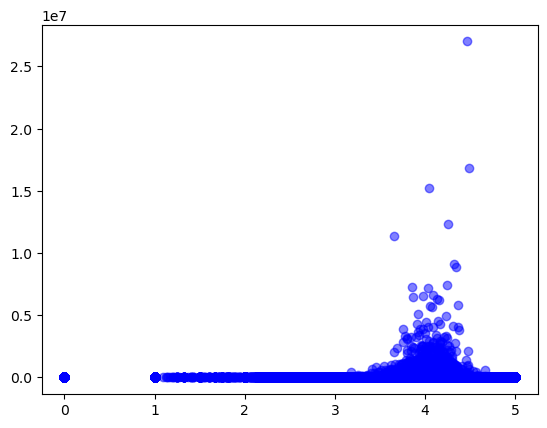

0.015256399747704081


In [14]:
plt.scatter(authors['average_rating'] ,authors['ratings_count'], color='blue', marker='o',alpha=0.5)#scatterplot of average ratings and rating count
plt.show()
print(authors['average_rating'].corr(authors['ratings_count']))  #correlation between average ratings and rating count

The correlation between average ratings and rating count is very close to 0, that indicates that there is no relationship between the two variables.

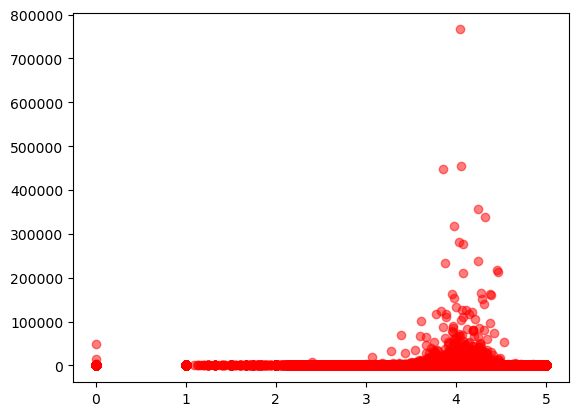

0.012478842829973628


In [15]:
plt.scatter(authors.average_rating, authors.fans_count, color='red', marker='o', alpha=0.5)

plt.show()

print(authors['average_rating'].corr(authors['fans_count']))

The correlation between average ratings and fans count is very close to 0, that indicates that there is no relationship between the two variables.

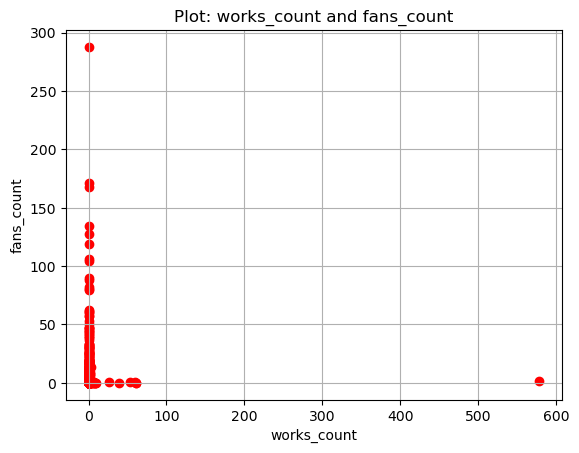

0.005022755324341809


In [16]:
X = authors[["works_count"]]
Y = authors[["fans_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='red', marker='o')

plt.title('Plot: works_count and fans_count')
plt.xlabel('works_count')
plt.ylabel('fans_count')
plt.grid(True)


plt.show()

correlation = df_standardized['X_standardized'].corr(df_standardized['Y_standardized'])
print(correlation)

The correlation between works count and fans count is very close to 0, that indicates that there is no relationship between the two variables.

# Analize books

In [17]:
books.describe()

,id,author_id,work_id,average_rating,ratings_count,text_reviews_count
count,99984.000000,9.998400e+04,9.998400e+04,99984.000000,9.998400e+04,99984.000000
mean,84819.740098,6.843063e+05,2.858894e+06,3.827090,4.522036e+04,1253.207613
std,51714.990145,2.315750e+06,9.421976e+06,0.692622,2.658542e+05,5678.835099
min,2.000000,4.000000e+00,6.200000e+01,0.000000,0.000000e+00,0.000000
25%,39873.750000,7.419000e+03,8.251775e+04,3.710000,5.800000e+01,5.000000
50%,82298.500000,2.418600e+04,1.683725e+05,3.930000,5.910000e+02,41.000000
75%,128059.250000,7.098400e+04,1.716845e+06,4.130000,5.843000e+03,302.000000
max,180140.000000,2.097942e+07,8.972161e+07,5.000000,7.377351e+06,116930.000000


## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1:** Plot the number of books for each author in descending order.

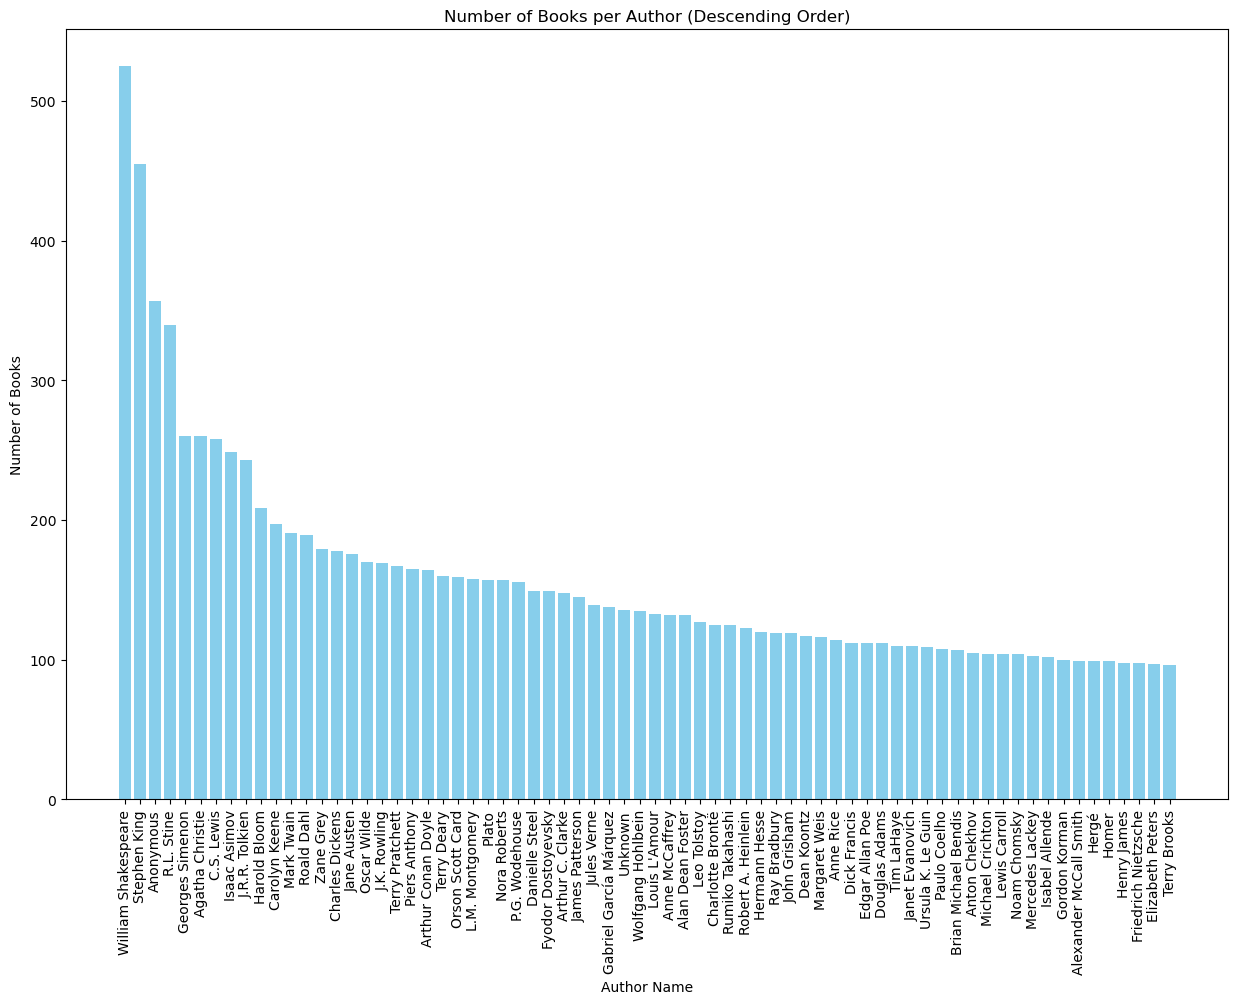

In [18]:
import matplotlib.pyplot as plt

counts = books['author_name'].value_counts().sort_values(ascending=False).head(70)

plt.figure(figsize=(15, 10))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Number of Books per Author (Descending Order)')
plt.xlabel('Author Name')
plt.ylabel('Number of Books')
plt.xticks(rotation=90)
plt.show()

**Request 2.2:**  Which book has the highest number of reviews?

In [ ]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

**Request 2.3:** Which are the top ten and ten worst books concerning the average score?

In [ ]:
books.nlargest(10, "average_rating")

In [ ]:
books.nsmallest(10, "average_rating")

**Request 2.4:** Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [31]:
books.language.head(30)
#there are some spazi vuoti

0     eng
1     eng
2     eng
3     eng
4     eng
5     eng
6     eng
7     eng
8     eng
9     eng
10    eng
11    eng
12       
13    eng
14       
15    eng
16       
17    eng
18    eng
19    eng
20    eng
21    eng
22    eng
23    eng
24    eng
25    eng
26    eng
27    eng
28    eng
29    eng
Name: language, dtype: object

In [36]:
for i in range(len(books.language)):
    if books.language[i]=='':
        print(i)
        
#drop or nondrop?        

12
14
16
37
38
39
51
67
69
73
79
84
85
91
98
104
107
110
135
137
142
143
144
148
149
155
158
162
164
165
166
167
168
169
170
171
175
176
178
179
180
181
182
183
186
188
194
195
196
197
200
202
203
204
205
214
216
222
231
232
233
234
235
242
243
250
252
253
254
271
272
276
277
278
279
280
284
287
288
291
293
296
300
312
314
322
325
332
333
334
335
338
341
342
345
348
349
350
351
352
354
357
358
365
367
368
369
371
373
374
375
377
378
380
381
385
386
389
395
396
397
398
399
400
402
403
404
405
407
409
411
412
414
416
417
418
419
421
423
427
430
432
433
443
444
447
448
450
451
453
456
457
460
461
462
463
464
465
466
467
468
477
479
480
482
483
484
485
486
492
494
495
496
500
501
519
520
522
523
524
525
526
527
528
529
530
541
544
545
548
551
552
559
560
561
563
564
566
567
568
570
571
579
580
582
583
587
588
589
590
592
593
594
595
597
598
599
606
607
611
612
615
617
618
621
623
626
627
628
629
631
633
634
635
636
637
638
639
640
642
644
645
646
647
648
649
650
651
652
653
654
657
658
659

8051
8052
8054
8062
8065
8069
8070
8073
8074
8075
8076
8077
8078
8079
8080
8085
8091
8093
8094
8097
8098
8104
8105
8106
8107
8109
8117
8118
8119
8121
8122
8123
8124
8126
8127
8129
8134
8135
8136
8140
8142
8143
8145
8146
8153
8154
8155
8159
8160
8165
8166
8167
8168
8169
8170
8175
8178
8179
8180
8181
8182
8185
8188
8190
8191
8193
8194
8198
8199
8200
8204
8205
8206
8207
8223
8225
8226
8227
8228
8229
8230
8231
8232
8234
8236
8242
8244
8246
8247
8248
8249
8251
8253
8254
8256
8259
8260
8263
8265
8272
8273
8274
8275
8276
8287
8290
8293
8296
8297
8299
8300
8303
8308
8310
8312
8314
8315
8316
8317
8319
8321
8325
8326
8327
8329
8336
8338
8340
8341
8345
8346
8349
8350
8351
8352
8353
8355
8356
8358
8361
8362
8363
8365
8367
8369
8374
8375
8376
8377
8378
8381
8382
8394
8395
8396
8400
8401
8403
8404
8405
8408
8415
8418
8420
8423
8426
8429
8430
8431
8432
8434
8440
8455
8459
8461
8464
8465
8468
8470
8471
8472
8473
8474
8478
8484
8486
8487
8489
8490
8492
8494
8497
8500
8501
8502
8503
8504
8505
8506
8507


16219
16220
16226
16231
16232
16235
16237
16239
16242
16249
16257
16258
16259
16262
16274
16277
16278
16279
16281
16286
16296
16300
16304
16305
16307
16309
16310
16311
16313
16315
16318
16325
16330
16333
16336
16338
16339
16341
16347
16352
16356
16360
16361
16362
16366
16371
16373
16375
16376
16378
16381
16384
16386
16387
16388
16391
16393
16394
16396
16398
16399
16401
16406
16408
16410
16412
16416
16417
16421
16424
16427
16428
16429
16433
16440
16441
16442
16444
16445
16447
16448
16449
16450
16451
16452
16458
16460
16462
16465
16466
16469
16472
16484
16485
16490
16492
16496
16497
16499
16500
16501
16502
16505
16507
16508
16510
16512
16513
16514
16515
16516
16519
16524
16525
16526
16527
16528
16529
16530
16531
16541
16543
16544
16545
16551
16553
16554
16556
16559
16560
16561
16562
16563
16564
16567
16572
16575
16576
16577
16578
16579
16580
16583
16587
16589
16590
16593
16595
16596
16598
16599
16600
16601
16602
16603
16604
16607
16608
16609
16610
16611
16613
16614
16617
16619
16620
1662

25199
25202
25203
25205
25206
25207
25208
25209
25210
25211
25212
25214
25215
25216
25218
25219
25220
25222
25225
25228
25230
25233
25235
25238
25246
25248
25252
25253
25254
25255
25256
25257
25258
25262
25263
25266
25268
25273
25276
25278
25280
25282
25283
25286
25287
25290
25291
25292
25294
25295
25297
25298
25299
25300
25301
25302
25303
25307
25309
25311
25312
25313
25315
25316
25317
25321
25322
25323
25329
25330
25331
25332
25334
25337
25339
25340
25341
25342
25343
25344
25345
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25360
25372
25377
25383
25386
25388
25390
25392
25401
25404
25405
25406
25407
25410
25411
25412
25413
25414
25415
25416
25418
25423
25424
25425
25426
25427
25428
25431
25433
25434
25435
25437
25438
25439
25442
25445
25450
25456
25457
25458
25459
25460
25463
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25489
25490
25492
25493
25495
25496
25497
25498
25499
25500
2550

32935
32936
32938
32939
32940
32942
32945
32948
32949
32950
32951
32952
32954
32956
32957
32960
32961
32963
32964
32965
32967
32969
32970
32971
32972
32973
32974
32975
32976
32984
32985
32986
32987
32988
32989
32991
32994
32995
32997
32998
33000
33001
33007
33010
33011
33012
33015
33019
33022
33023
33024
33025
33027
33028
33036
33037
33040
33041
33042
33043
33044
33045
33046
33047
33048
33050
33051
33052
33053
33056
33060
33061
33062
33063
33064
33065
33068
33070
33071
33072
33075
33076
33078
33079
33080
33081
33084
33086
33087
33088
33100
33101
33103
33104
33107
33108
33109
33112
33114
33117
33119
33123
33124
33126
33128
33130
33131
33136
33137
33138
33139
33141
33142
33144
33145
33146
33147
33148
33149
33150
33155
33158
33161
33162
33166
33167
33168
33169
33170
33171
33172
33173
33174
33175
33176
33177
33178
33179
33180
33185
33188
33189
33191
33192
33195
33197
33200
33201
33205
33206
33211
33212
33213
33215
33216
33219
33225
33226
33227
33228
33231
33232
33233
33234
33235
33239
3324

40774
40775
40777
40779
40781
40782
40783
40784
40785
40786
40787
40788
40789
40790
40791
40793
40796
40797
40798
40805
40807
40810
40814
40817
40822
40823
40824
40825
40827
40829
40830
40832
40833
40836
40837
40839
40840
40842
40843
40844
40845
40851
40852
40854
40855
40858
40859
40863
40865
40869
40871
40873
40874
40875
40880
40882
40883
40889
40890
40895
40897
40898
40899
40900
40901
40902
40904
40905
40906
40907
40910
40911
40912
40913
40914
40918
40919
40920
40921
40923
40926
40927
40928
40929
40930
40931
40932
40934
40936
40940
40942
40943
40945
40947
40949
40951
40952
40954
40955
40956
40958
40960
40962
40965
40966
40967
40968
40974
40975
40976
40979
40982
40983
40995
40997
40999
41000
41001
41005
41006
41011
41015
41017
41018
41019
41020
41022
41023
41024
41025
41026
41031
41032
41034
41036
41038
41039
41041
41047
41050
41053
41055
41058
41060
41061
41065
41068
41077
41080
41082
41084
41085
41086
41087
41088
41089
41091
41092
41093
41099
41100
41101
41103
41105
41106
41107
4110

49227
49230
49231
49232
49233
49234
49236
49237
49238
49239
49240
49241
49242
49243
49245
49247
49248
49249
49251
49252
49253
49254
49255
49257
49259
49260
49261
49262
49263
49265
49266
49268
49269
49270
49271
49275
49276
49278
49279
49280
49282
49283
49284
49286
49287
49288
49289
49290
49292
49295
49296
49302
49305
49307
49308
49310
49311
49312
49313
49317
49318
49319
49321
49327
49328
49329
49332
49333
49334
49335
49336
49337
49339
49340
49344
49348
49349
49350
49352
49354
49356
49357
49358
49359
49360
49361
49362
49365
49369
49372
49373
49374
49375
49376
49377
49378
49380
49381
49384
49389
49390
49396
49398
49404
49406
49407
49408
49409
49410
49411
49412
49413
49414
49416
49421
49429
49431
49433
49435
49436
49437
49438
49441
49442
49444
49446
49448
49449
49452
49454
49455
49456
49460
49462
49467
49468
49471
49472
49473
49474
49475
49476
49478
49480
49482
49484
49485
49486
49488
49489
49490
49491
49493
49494
49495
49496
49503
49505
49507
49508
49510
49513
49514
49516
49517
49518
4951

57403
57404
57405
57406
57408
57410
57413
57415
57419
57421
57422
57424
57426
57427
57428
57429
57430
57432
57433
57434
57435
57436
57437
57438
57439
57444
57445
57449
57450
57451
57452
57453
57454
57456
57457
57460
57461
57462
57463
57464
57465
57466
57469
57470
57474
57475
57476
57477
57479
57480
57481
57482
57483
57484
57485
57486
57487
57489
57490
57491
57494
57495
57496
57497
57498
57499
57500
57501
57502
57503
57505
57506
57507
57508
57510
57513
57514
57516
57518
57519
57521
57522
57523
57524
57525
57526
57527
57528
57529
57530
57531
57534
57536
57537
57538
57539
57541
57542
57543
57546
57548
57549
57550
57551
57552
57556
57559
57560
57561
57562
57565
57566
57567
57568
57569
57570
57573
57574
57576
57577
57578
57580
57583
57584
57586
57592
57594
57595
57597
57598
57599
57600
57603
57604
57610
57613
57614
57615
57616
57619
57624
57625
57627
57628
57632
57633
57634
57635
57637
57639
57641
57642
57643
57644
57646
57647
57648
57652
57655
57658
57661
57662
57663
57664
57668
57671
5767

68451
68454
68455
68457
68464
68465
68466
68468
68471
68480
68481
68487
68492
68493
68496
68497
68498
68499
68501
68502
68503
68504
68507
68508
68509
68510
68512
68513
68514
68515
68516
68518
68521
68525
68526
68527
68529
68530
68535
68541
68546
68547
68550
68556
68562
68563
68565
68566
68567
68568
68569
68570
68571
68572
68573
68575
68576
68577
68579
68580
68581
68582
68583
68584
68585
68586
68587
68589
68590
68591
68592
68597
68600
68601
68602
68603
68605
68606
68607
68609
68610
68612
68614
68615
68616
68617
68618
68620
68622
68623
68624
68626
68628
68629
68630
68632
68633
68634
68635
68636
68637
68638
68640
68641
68643
68651
68653
68654
68655
68657
68658
68660
68662
68663
68664
68665
68666
68667
68669
68672
68673
68675
68676
68677
68678
68679
68680
68681
68684
68685
68686
68687
68688
68689
68690
68691
68692
68699
68703
68704
68708
68709
68712
68713
68716
68717
68721
68722
68723
68726
68730
68733
68734
68735
68736
68738
68739
68740
68743
68744
68745
68746
68748
68749
68750
68751
6875

75299
75301
75303
75304
75305
75306
75307
75308
75311
75314
75317
75320
75321
75322
75324
75325
75326
75328
75330
75331
75336
75339
75340
75341
75342
75343
75344
75345
75346
75347
75349
75351
75352
75353
75354
75355
75357
75358
75359
75360
75362
75364
75365
75366
75367
75369
75371
75372
75374
75375
75376
75377
75380
75381
75382
75383
75386
75387
75388
75389
75390
75391
75392
75394
75395
75397
75405
75409
75411
75412
75413
75414
75415
75416
75417
75418
75421
75422
75423
75424
75426
75427
75428
75429
75433
75434
75444
75445
75446
75447
75448
75449
75450
75452
75454
75455
75456
75457
75458
75459
75460
75462
75465
75470
75478
75479
75480
75481
75482
75483
75484
75487
75488
75489
75490
75491
75495
75497
75500
75501
75502
75503
75504
75507
75508
75509
75510
75513
75514
75515
75518
75521
75523
75525
75532
75533
75535
75536
75537
75538
75539
75540
75541
75542
75543
75544
75545
75546
75547
75548
75549
75551
75552
75554
75555
75557
75558
75559
75560
75561
75562
75564
75568
75569
75570
75571
7557

83052
83053
83057
83059
83061
83062
83064
83065
83066
83067
83068
83070
83072
83073
83074
83075
83076
83078
83079
83080
83083
83085
83086
83088
83090
83091
83092
83095
83098
83100
83101
83103
83104
83105
83106
83107
83109
83112
83113
83114
83116
83118
83119
83120
83121
83122
83123
83124
83125
83127
83128
83129
83130
83131
83132
83133
83136
83137
83138
83142
83143
83144
83145
83146
83148
83149
83150
83151
83152
83153
83154
83155
83156
83159
83162
83163
83170
83172
83173
83174
83175
83176
83177
83178
83179
83182
83184
83186
83187
83189
83193
83195
83196
83197
83198
83199
83200
83201
83208
83209
83210
83211
83212
83215
83218
83219
83220
83222
83226
83227
83230
83233
83234
83235
83236
83239
83240
83245
83246
83247
83248
83249
83250
83251
83252
83253
83257
83261
83264
83265
83266
83267
83269
83270
83273
83274
83275
83277
83278
83279
83280
83282
83284
83285
83288
83289
83290
83292
83293
83297
83298
83299
83301
83304
83305
83306
83310
83312
83313
83315
83316
83317
83318
83319
83320
83322
8332

92256
92258
92260
92261
92262
92263
92264
92266
92267
92268
92269
92270
92271
92272
92273
92275
92278
92279
92280
92281
92283
92284
92287
92288
92289
92290
92291
92292
92293
92295
92298
92299
92300
92301
92302
92303
92304
92305
92307
92308
92309
92310
92311
92312
92313
92314
92315
92317
92318
92321
92322
92324
92327
92328
92329
92330
92333
92335
92336
92338
92339
92341
92342
92343
92346
92348
92349
92350
92353
92354
92355
92356
92357
92360
92361
92362
92363
92366
92367
92368
92369
92370
92371
92372
92373
92375
92377
92379
92380
92381
92382
92383
92384
92385
92387
92388
92389
92390
92391
92392
92393
92394
92395
92396
92397
92399
92401
92402
92404
92405
92406
92407
92408
92409
92411
92412
92417
92419
92421
92422
92423
92424
92426
92427
92428
92432
92433
92434
92435
92437
92438
92439
92440
92441
92443
92444
92446
92449
92450
92453
92457
92459
92460
92461
92462
92463
92464
92466
92467
92468
92469
92470
92471
92478
92479
92480
92482
92486
92487
92488
92489
92490
92494
92495
92497
92499
9250

# #continuing with non dropped dataset

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(1, 0, 'eng'),
  Text(2, 0, 'en-US'),
  Text(3, 0, 'spa'),
  Text(4, 0, 'ger'),
  Text(5, 0, 'fre'),
  Text(6, 0, 'en-GB'),
  Text(7, 0, 'por'),
  Text(8, 0, 'per'),
  Text(9, 0, 'ita'),
  Text(10, 0, 'rus'),
  Text(11, 0, 'jpn'),
  Text(12, 0, 'mul'),
  Text(13, 0, 'zho'),
  Text(14, 0, 'nl'),
  Text(15, 0, 'swe'),
  Text(16, 0, 'tur'),
  Text(17, 0, 'ara'),
  Text(18, 0, 'grc'),
  Text(19, 0, 'pol')])

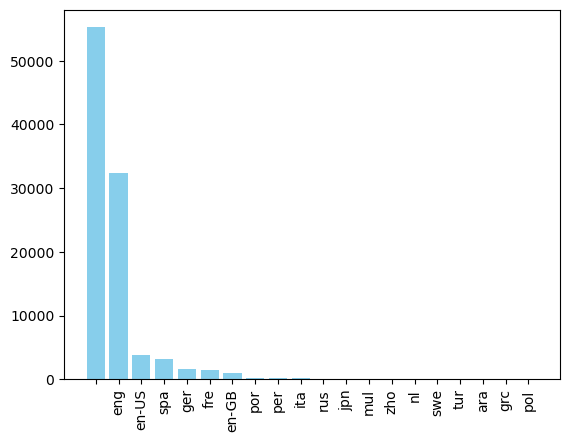

In [27]:
languages = books['language'].value_counts().head(20)
plt.bar(languages.index, languages.values, color='skyblue')
plt.xticks(rotation=90)

**Request 2.5:** How many books have more than 250 pages?

Notice that there are some entries that have a void string instead of the number of pages.

In [37]:
# create a view that excludes the entries with void string
df = books[books["num_pages"] != ""]

# execute query
result = df[df["num_pages"].astype(int) > 250].shape[0]

print(result)

41504


**Request 2.6:** Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Jesse Russell'),
  Text(1, 0, 'Ronald Cohn'),
  Text(2, 0, 'Anonymous'),
  Text(3, 0, 'Unknown'),
  Text(4, 0, 'Source Wikipedia'),
  Text(5, 0, 'Various'),
  Text(6, 0, 'Philip M. Parker'),
  Text(7, 0, 'U.S. Congress'),
  Text(8, 0, 'Books LLC'),
  Text(9, 0, 'Livres Groupe'),
  Text(10, 0, 'Walt Disney Company'),
  Text(11, 0, 'National Aeronautics and Space Administration'),
  Text(12, 0, 'Source Wikia'),
  Text(13, 0, 'U.S. House of Representatives'),
  Text(14, 0, 'Fuente Wikipedia'),
  Text(15, 0, 'William Shakespeare'),
  Text(16, 0, 'Organisation for Economic Co-operation and Development'),
  Text(17, 0, 'Arthur Conan Doyle'),
  Text(18, 0, 'McGraw-Hill Education'),
  Text(19, 

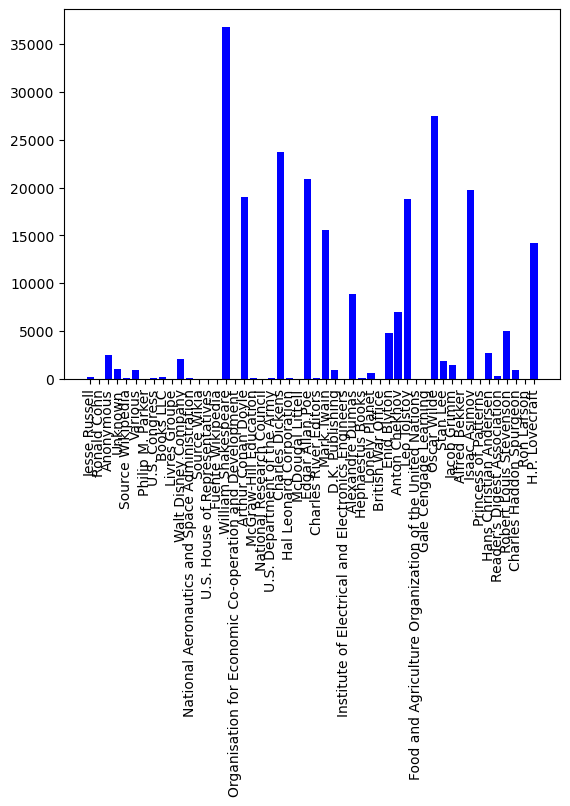

In [11]:
top_authors = authors.sort_values(by="works_count", ascending=False).head(50)
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)

## [RQ3] Let’s have a historical look at the dataset!

**Request 3.1:** Write a function that takes as input a year and returns as output the following information:

* The number of books published that year.
* The total number of pages written that year.
* The most prolific month of that year.
* The longest book written that year.

We have to cope on the number of pages, how do we work in this case?

In [45]:
books.num_pages

0        870
1        309
2        352
3        435
4        734
        ... 
99979    289
99980    450
99981    393
99982      4
99983    718
Name: num_pages, Length: 99984, dtype: object

In [50]:
for i in range(len(books.num_pages)):
    if books.num_pages[i]==0:
        print(i)

591
637
646
773
776
1192
1206
1416
1618
1627
1730
1768
1788
1793
1893
1900
2097
2250
2254
2453
2649
2780
2789
2790
3003
3038
3058
3148
3392
3531
3710
4003
4004
4015
4022
4027
4077
4092
4110
4335
4365
4465
4744
4775
4792
4807
4834
4894
4924
5108
5136
5142
5432
5433
5452
5582
5619
5715
6188
6267
6316
6341
6355
6399
6417
7015
7016
7148
7430
7487
7521
7681
7873
7999
8065
8094
8098
8104
8114
8146
8325
8413
8459
8645
8648
8650
8910
8911
9101
9207
9273
9287
9535
10115
10137
10180
10477
10540
10542
10543
10562
10581
10859
10931
11172
11252
11253
11349
11419
11475
11476
11571
11718
11725
12040
12087
12141
12176
12415
12465
12477
12511
12647
12814
13000
13007
13011
13158
13249
13260
13408
13472
13609
13679
13682
13839
13841
13842
13843
13844
13846
13849
13855
13857
13858
13863
13867
13877
13879
13880
13882
13889
13894
13905
13909
13911
13919
13926
13930
13933
13936
13942
13948
13964
14001
14002
14024
14026
14028
14029
14030
14031
14033
14034
14035
14039
14042
14045
14060
14063
14089
14098
14099


There are so many books that has no pages.

In [52]:
def look_by_year(books, year):
    books_year = books["original_publication_date" == year]
    n_books = books_year.shape[0]

    tot_pages = sum(books_year["num_pages"]) 
    prolific_month = "" # todo
    longest_book = "" #todo

    return n_books, tot_pages, prolific_month, longest_book

**Request 3.2:** Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

TODO

**Request 3.3:** Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

**Request 4.1:** You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
authors[(authors["name"] == authors["name"]) & (authors["id"] != authors["id"])]

**Request 4.2:** Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

**Request 4.3:** What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

**Request 4.4:** What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

**Request 5.1a:** Plot the top 10 most influential authors regarding their fan count and number of books.

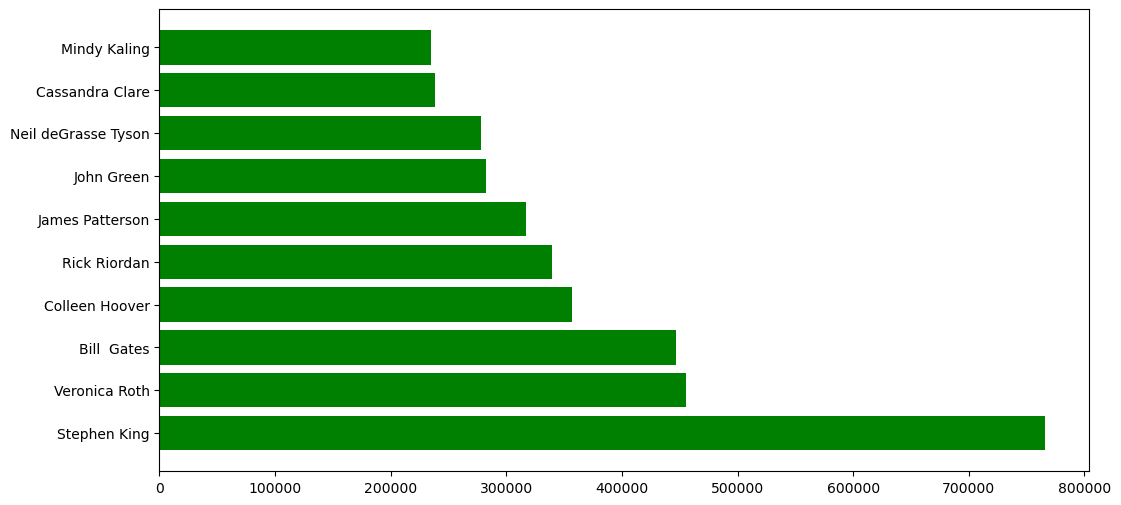

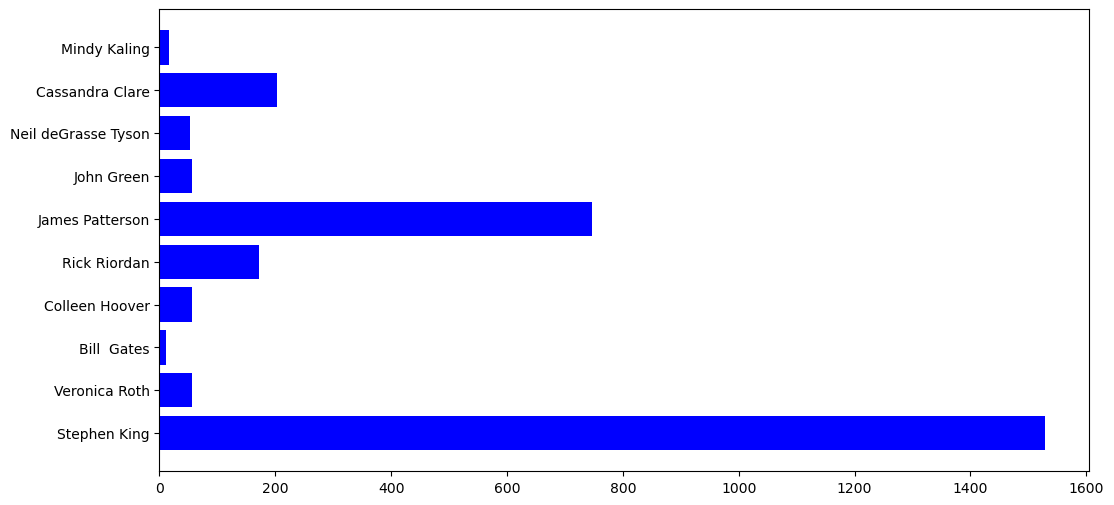

In [23]:
# count the actual number of books written by every author using the length of the list of his book ids.
authors["book_count"] = authors["work_ids"].apply(len)

# 10 most influential authors regarding their fan count
x = authors.nlargest(10, "fans_count")

# plot the data
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["fans_count"], color = 'green', label = 'Fan Count')
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["book_count"], color = 'blue', label = 'Book Count')
plt.show()

**Request 5.1b:** Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [64]:
# most influential author
m_inf = authors.nlargest(1, "fans_count")
print("The most influential author, having by far the largest fanbase is:", m_inf["name"].to_string(index = False))

The most influential author, having by far the largest fanbase is: Stephen King


**Request 5.2:** Have they published any series of books? If any, extract the longest series name among these authors.

In [63]:
# create a new dataframe containing only the books written by the top 10 authors
top_authors_books = books[books["author_id"].isin(list(x["id"]))]

# get the series authors by their "series position" to find who has written series, and use max position to determine their longest series' length.
author_series_lengths = top_authors_books.groupby(["author_id", "author_name"])["series_position"].max().reset_index()

# return the highest series position, thus the longest series author and name
author_series = top_authors_books.groupby(["author_id", "author_name", "series_name"])["series_position"].max().reset_index()
max_series = author_series[author_series["series_position"] == author_series["series_position"].max()]

print("Authors of series are:")
print(author_series_lengths["author_name"].to_string(index = False))

print("\nThe author of the longest series is:")
print(max_series["author_name"].to_string(index = False))
print("And the series is:")
print(max_series["series_name"].to_string(index = False))

Authors of series are:
       Stephen King
    James Patterson
Neil deGrasse Tyson
       Rick Riordan
        Bill  Gates
    Cassandra Clare
       Mindy Kaling
         John Green
      Veronica Roth
     Colleen Hoover

The author of the longest series is:
Rick Riordan
And the series is:
Percy Jackson and the Olympians


**Request 5.3:** How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

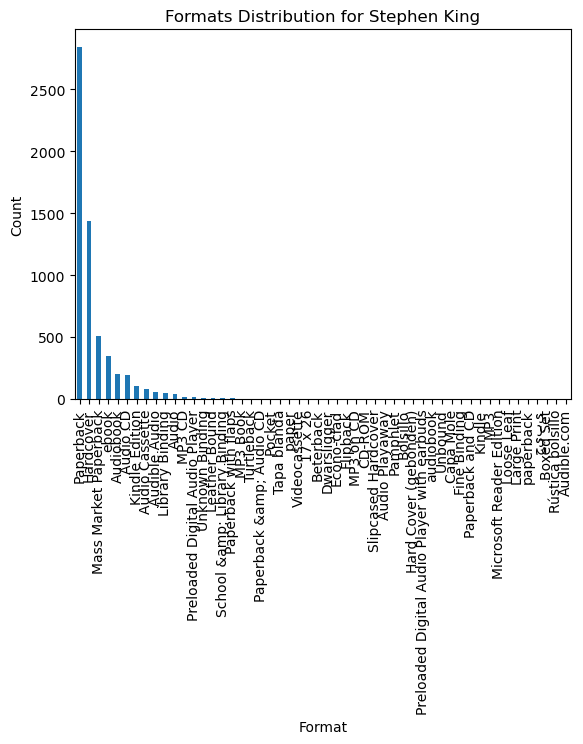

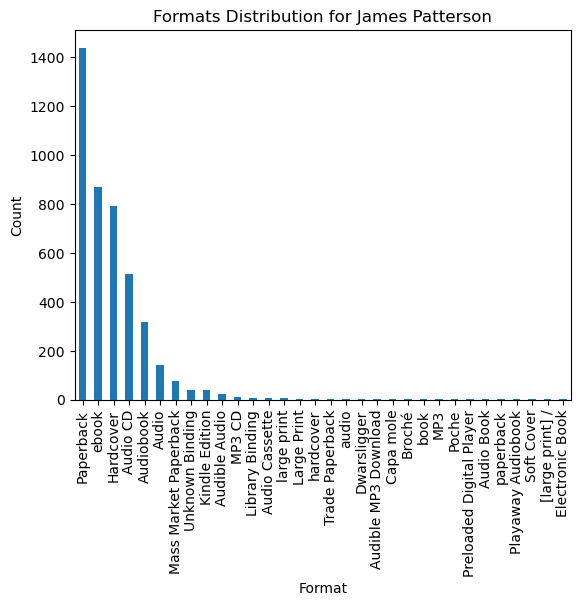

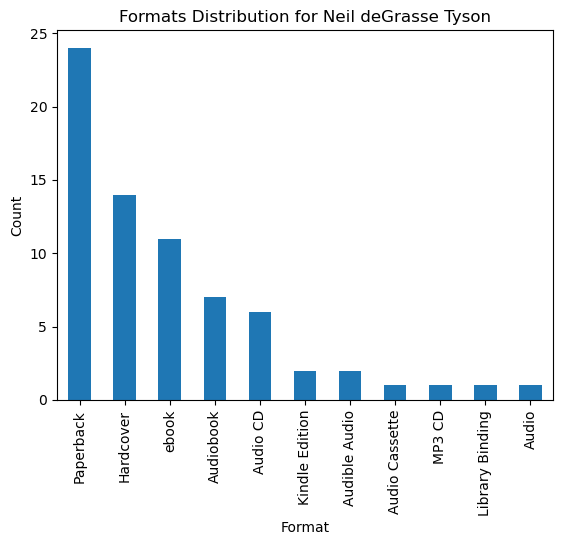

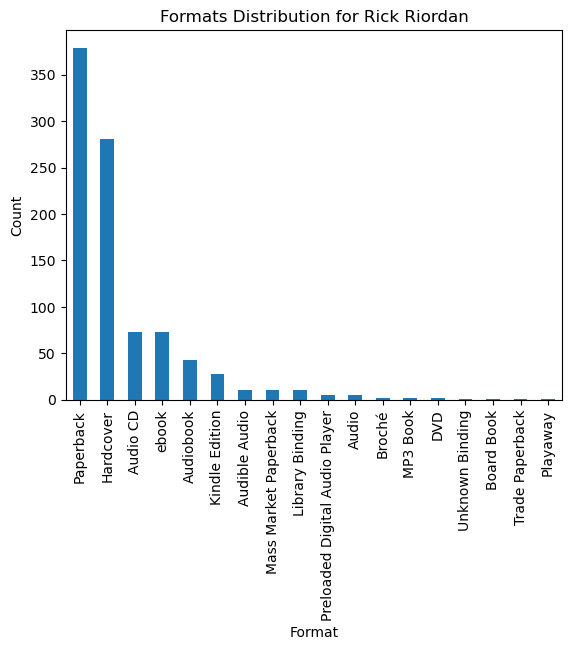

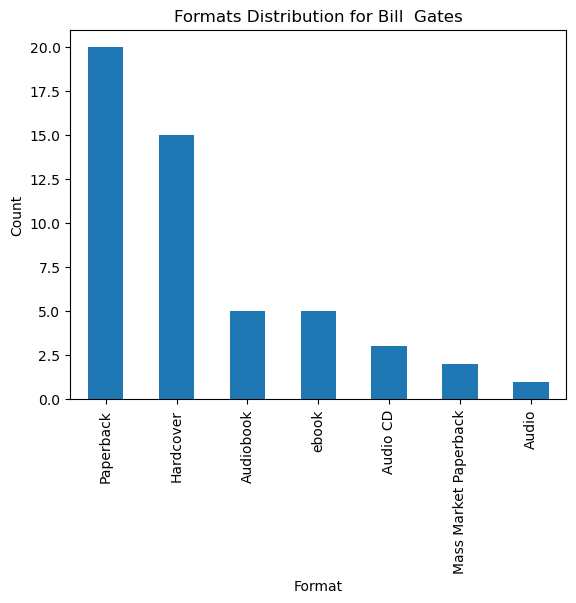

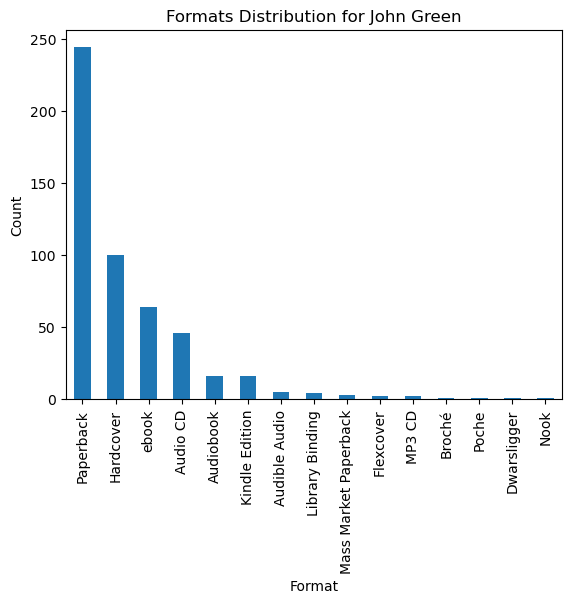

d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Programs\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Program

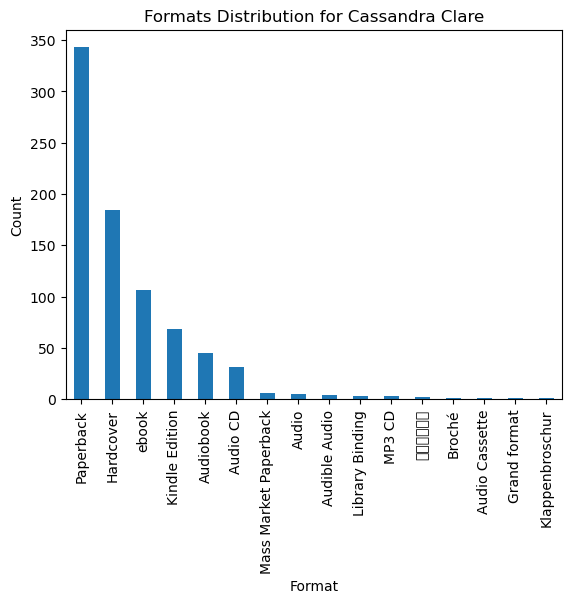

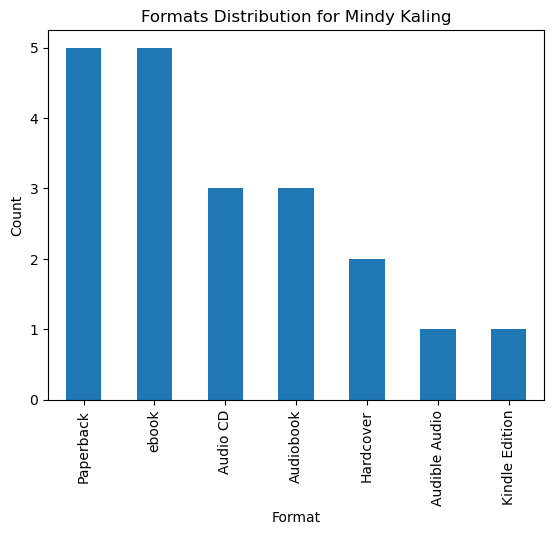

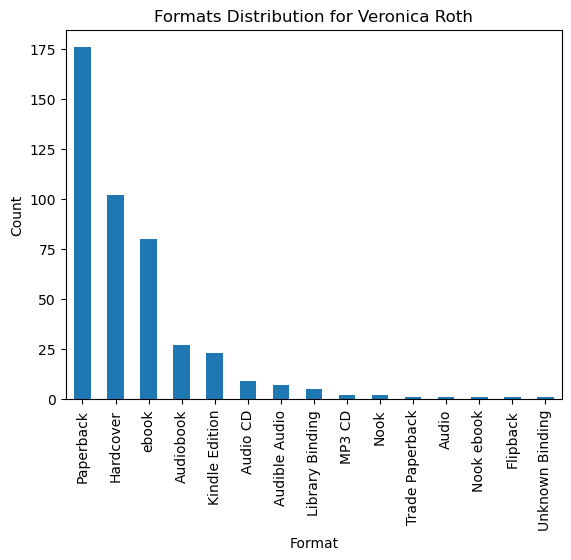

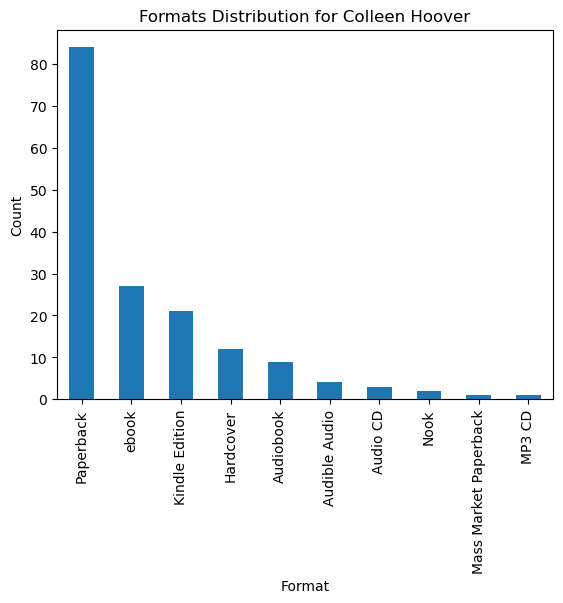

In [75]:
# to find the authors published in different formats from the top 10
authors_with_different_formats = top_authors_books[top_authors_books.duplicated(subset=["author_id"], keep = False)]
authors_with_different_formats = authors_with_different_formats[authors_with_different_formats["format"] != ""]

# to avoid name repetition
unique_author_ids = authors_with_different_formats["author_id"].unique()

# create a separate chart for each author with multiple formats
for author_id in unique_author_ids:
    author_data = authors_with_different_formats[authors_with_different_formats["author_id"] == author_id]
    author_name = author_data["author_name"].values[0]
    format_distribution = author_data["format"].value_counts()
    
    format_distribution.plot(kind='bar')
    plt.title(f"Formats Distribution for {author_name}")
    plt.xlabel("Format")
    plt.ylabel("Count")
    plt.show()

**Comments on the graphs above:** we can see that the books are mainly published in paperback and hardcover formats, whereas the "newer" digital formats are very few. This would be due to 3 main reasons: 
1- the age of most of the books written by these authors since audiobooks and ebook formats are relatively new.
2- even with more widely available digital formats now, these are authors of novels and readers who usually enjoy leisurely reading prefer the physical format of paper, rather than reading through a screen.
3- Once a book has been published in a digital format, there is no need to republish it using another editorial, since it is already on the internet, a more universal "bookstore".

**Request 5.4:** Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

- https://bhm.scholasticahq.com/article/38021
- https://priyanka-ddit.medium.com/how-to-deal-with-imbalanced-dataset-86de86c49
- https://compass.onlinelibrary.wiley.com/doi/10.1111/soc4.12962

You can even ask ChatGPT or any other LLM chatbot tool: try to formulate a prompt that provides helpful information about it. Put that information in your notebook and provide comments on what you found.

TODO

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

    Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?
    For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

**Request 6.1:** Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [66]:
# step 1: transform the publication date entry to datetime format
top_authors_books["original_publication_date"] = pd.to_datetime(top_authors_books["original_publication_date"], format = 'mixed')

# calculate time gap between consecutive "original" publications and add it into a column for all books
top_authors_books["time_gap"] = top_authors_books.groupby(["author_id", "series_id"])["original_publication_date"].diff()

# calculate the average time gap for books in a series and not in a series, according to the new column created
average_time_gap_series = top_authors_books[top_authors_books["series_id"].notna()]["time_gap"].mean()
average_time_gap_non_series = top_authors_books[top_authors_books["series_id"].isna()]["time_gap"].mean()

# print(f"Average Time Gap for Books in a Series: {average_time_gap_series}")
# print(f"Average Time Gap for Books Not in a Series: {average_time_gap_non_series}")
print(top_authors_books)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 10-01, at position 165

**What do we expect to see?** As expected the books that belong to a series have a more periodic and regular output from the authors(on average), and this logically makes sense following the idea that the author is breaking down a full story into separate books.
Books that do not belong to a series however do not have a well-defined average gap between them since they are independent works and do not follow any periodic output "expectation" from the public.

**Request 6.2:** For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [67]:
# define a new column using the datetime format of the original publication date
top_authors_books['year'] = top_authors_books["original_publication_date"].dt.year
writers_counts = top_authors_books.groupby(['author_name', 'year']).size().reset_index(name='Count')

# plot the publication history for each author
writers = writers_counts['author_name'].unique()
for writer in writers:
    author_data = writers_counts[writers_counts['author_name'] == writer]
    plt.plot(author_data['year'], author_data['Count'], label=writer)

plt.title("Publication History of Authors")
plt.xlabel("Year")
plt.ylabel("Number of Books Published")
plt.legend()
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

## [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

**Request 7.1:** Estimate the probability that a book has over 30% of the ratings above 4.

---

We can do this by counting how many books have 30% of the rating above 4 (i.e. a rating of 5 since you can only give an integer beteween 1 and 5 as rating) and dividing it by the total number of books.

In [20]:
books[books["rating_dist"] == "5:-1|4:1|3:1|2:0|1:0|total:1"]
books[books["rating_dist"] == "5:0|4:0|3:3|2:-1|1:-1|total:1"]

,id,title,authors,author_name,author_id,work_id,language,average_rating,rating_dist,ratings_count,text_reviews_count,publication_date,original_publication_date,format,num_pages,series_id,series_name,series_position
7011288,25479306,A Business Trip to New York,None,I Talk You Talk Press,7451906,45251224,,5.0,5:0|4:0|3:3|2:-1|1:-1|total:1,1,0,,2014-09-04,,,,,


In [21]:
def has_30p_above_four(rating_dist):
    pattern = r"5:([0-9]+)\|4:[0-9]+\|3:[0-9]+\|2:[0-9]+\|1:[0-9]+\|total:([0-9]+)"

    match = re.search(pattern, rating_dist)
    if int(match.group(1)) > 0.3 * int(match.group(2)):
        return True
    else:
        return False

df = books.drop(index = [6650514, 7011288]) # we remove this specific cases because the rating distribution is wrong
above_four = sum(df["rating_dist"].apply(has_30p_above_four))

result = above_four / df.shape[0]
print(result)

0.44710277400170106


**Request 7.2:** Estimate the probability that an author publishes a new book within two years from its last work.

TODO

**Request 7.3:** In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

---

We call the "Book is in the worst books list" event $A$ and "Book has more than 700 pages" event $B$. We use Bayes' formula:

$\mathbb{P}(\text{A | B}) = \frac{\mathbb{P}(\text{B | A}) \;\cdot\; \mathbb{P}(\text{A}) }{\mathbb{P}(\text{B})}$

* $\mathbb{P}(\text{A})$: the probability that a book is in the worst books list. Obtained by counting the entries in "The Worst Books of All Time" list and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B})$: the probability that a book has more than 700 pages. Obtained by counting the entries with more than 700 pages and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B | A})$: the probability of a book having more than 700 pages knowing that it is in the worst book list. Obtained by doing the second query over the books identified by first one.

In [22]:
df = books[books["num_pages"] != ""]

worst_books = pd.read_json(list_path, lines = True, nrows = 1)["books"][0]
worst_books = pd.DataFrame(worst_books)
worst_books["book_id"] = worst_books["book_id"].astype(int)
n_worst_books = worst_books.shape[0]
join = pd.merge(worst_books, df, left_on = "book_id", right_on = "id", how = "inner", suffixes = ["_w", "_b"])

pA = n_worst_books / df.shape[0]
pB = df[df["num_pages"].astype(int) > 700].shape[0] / (df.shape[0])
pBA = join[join["num_pages"].astype(int) > 700].shape[0] / (join.shape[0])
pAB = pBA * pA / pB

print("P(A | B), the probability of a book being included in the worst books list, knowing it has more than 700 pages: ", pAB)

pA:  0.0018689977439556517
pB:  0.02809184760020993
pBA:  0.0383475684155482
pAB:  0.002551328053421057


**Request 7.4:** Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

---

To check whether the X and Y are indipendent we can apply the definition of indipendence. Two events are indipendent if knowing that one happened does not change the probability of the second one appearing. Formally speaking, that is when:

$\mathbb{P}(X \cap Y) = \mathbb{P}(X) \cdot \mathbb{P}(Y)$

To reuse the previously calculated probabilities we can also add the definition of conditional probability:

$\mathbb{P}(X | Y) = \frac{\mathbb{P}(X \cap Y)}{\mathbb{P}(Y)}$

From which we obtain that if X and Y are indipendent:

$\mathbb{P}(X | Y) = \mathbb{P}(X)$

$\mathbb{P}(Y | X) = \mathbb{P}(Y)$


We called X as A and Y as B. Then to check for indipendence we can just check whether $\mathbb{P}(\text{A | B})$ and $\mathbb{P}(\text{B | A})$ are equal respectively to $\mathbb{P}(A)$ and $\mathbb{P}(B)$. To be precise indipendence is a two-way relation, so if one holds also the second must hold, this means we really only need to check one of those two.

In [25]:
# df["in_worst_book_list"] = df["id"].apply(lambda x: x in worst_books["book_id"].values)
# df["more_700_pages"] = df["num_pages"].apply(lambda x: x > 700)

print("Test 1:")
print("P(A), the probability of a book of the whole dataset to be in the worst books list: ", pA)
print("P(A | B), the probability of a book to be in the worst books list, knowing that it has more than 700 pages: ", pAB)

print("Test 2:")
print("P(B), the probability of book of the whole dataset to have more than 700 pages over the total: ", pB)
print("P(B | A), the probability of books to have more than 700 pages knowing that it is in the worst books list: ", pBA)

Percentage of worst book over total:  0.0018689977439556517
Percentage of book with more than 700 pages over total:  0.02809184760020993
Percentage of worst books in books with more than 700 pages 0.002551328053421057
Percentage of books with more than 700 in worst books 0.0383475684155482
Product of the single probabilities 5.250359978833835e-05
There is dipendence


As we can see the two events are dependent.

## [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

**Request 8.1:** Can you demonstrate that readers usually rate the longest books as the worst?

---

In [115]:
df = books[books["num_pages"] != ""]
df["num_pages"] = df.num_pages.astype(int)

# we try to remove outliers
df = df[(df["num_pages"] < 1500) & (df["num_pages"] != 0) & (df["average_rating"] != 0)]

C:\Users\Utente\AppData\Local\Temp\ipykernel_264\1800968357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_pages"] = df.num_pages.astype(int)


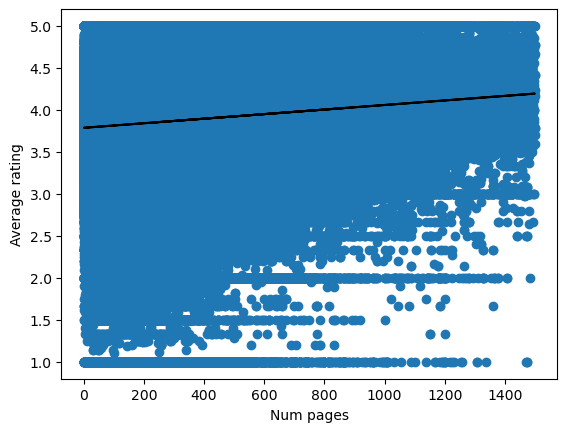

In [117]:
plt.scatter(df["num_pages"], df["average_rating"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Num pages")
plt.ylabel("Average rating")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.show()

This scatterplot is confusing, we try to use a heatmap.

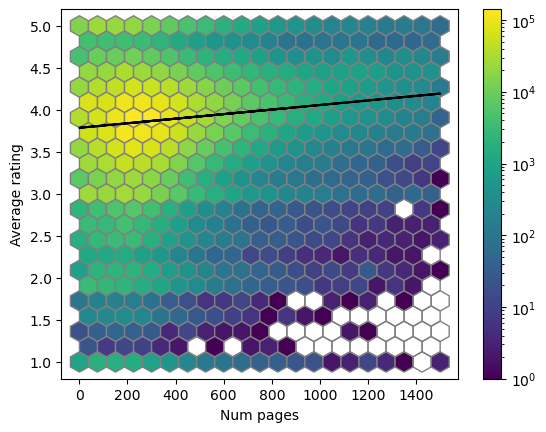

In [118]:
plt.hexbin(df["num_pages"], df["average_rating"], gridsize = 20, bins = "log", edgecolor = "gray")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.xlabel("Num pages")
plt.ylabel("Average rating")
plt.colorbar()

In [120]:
correlation = df["average_rating"].corr(df["num_pages"])
print("The correlation coefficient between 'average_rating' and 'num_pages' is:", correlation)

The correlation coefficient between 'average_rating' and 'num_pages' is: 0.09790234871325924


We see the correlation coefficient is and in the positive direction, hinting at a faint positive correlation between the number of pages and the average rating. Without our data selection the correlation is even fainter but always in a positive direction. This means that we can't demonstrate that readers usually rate the longest books as the worst, instead even if the effect is very little it's the opposite.

---

**Request 8.2:** Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

TODO

**Request 8.3:** About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

TODO

**Request 8.4:** It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

TODO

**Request 8.5:** Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

# Bonus points

## 1

**Request 1.1:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

In [ ]:
# IN PANDAS

print("Measuring Pandas performance...")
%timeit authors[authors["text_reviews_count"] >= 100]

# IN DASK

authors_dask = dd.from_pandas(authors, npartitions = 1)

print("Measuring Dask performance...")
%timeit authors_dask[authors_dask["text_reviews_count"] >= 100].compute()

**Request 1.2:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [ ]:
join = pd.merge(books, authors, left_on = "author_id", right_on = "id", how = "left")[["id_y"]]
authorless_istances = join["id_y"].isna().sum()
print("Authorless istances: ", authorless_istances)

In [ ]:
join = dd.merge(dd.from_pandas(books, npartitions = 1), dd.from_pandas(authors, npartitions = 1), left_on = "author_id", right_on = "id", how = "left")
authorless_instances = join["id_y"].isna().sum().compute()
print("Authorless instances: ", authorless_instances)

## 2 Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

To perform the text-mining analysis we created a list of tag words for specific literary genres that should help us identify a book and an author. List can have words in common as same concepts can appear in different genres (as "monster" can appear both in horror and fantasy genres) or when the same word is used with different meanings (as "chemistry" can appear both in romance and scientific books). Some words have spaces before and after to avoid finding it inside other words (as "art" in "artificial") or only before when we want to find also composed word (as for "dread" and "dreadful").

We decided to print out only the three most value tags. We decided to use the same method for both books and authors.

In [ ]:
comedy_tags = ["humor", "comedy", "satire", "funny", "laugh", "comical", "hilarious", "laughter", "light-hearted", "parody", "joke", "amusing", "whimsical", "lighthearted", "satirical", "witty", "silly", "absurd", "hilarity", "comedic", "farce", "irony", "sarcasm", "slapstick"]
action_tags = ["action", "adventure", "suspense", "thriller", "bravery", "excitement", "adrenaline", "tension", "intense", "escape", "dangerous", "fast-paced", "adversary", "hero", "spy", "villain", "combat", "fight", "chase", "explosion", "fighting", "danger", "martial art", "high-octane", "adrenaline", "rescue", "mission", "conspiracy", "intelligence", "agent", "secret"]
fantasy_tags = ["fantasy", "magic", "wizardry", "dragon", "god", "elf", "dwarf", "monster", "sword", "quest", "castle", "mythical", "prophecy", "fairy", "sorcery", "sorcerer", "witchcraft", "enchantment", "magician", "spellcasting", "conjuring", "curse", "alchemy", "mysticism", "occult", "supernatural", "sorcerer", "witch", "spell", "ritual", "arcane", "knowledge", "magical", "wizard"]
romance_tags = ["romance", "love", "relationship", "passion", "heartfelt", "heart", "attraction", "emotional", "romantic", "couple", "affection", "intimacy", "sweetheart", "desire", "chemistry", "flirting", "courtship", "kiss", "embrace", "lover", "seduction", "infatuation"]
mystery_tags = ["mystery", "detective", "suspense", "crime", "secrets", "clue", "mysterious", "victim", "suspicious", "suspicion", "death", "poison", "intrigue", "theft", "thief", "whodunit", "widow", "missing", "killer", "unsolved", "assassin", "twists", "investigation", "thriller", "clues", "sleuth", "police", "intrigue", "enigma", "puzzle", "murder", "conspiracy", "forensic", "stabbed", "solving", "sleuthing", "suspicion", "unraveling", "evidence", "schemes", "riddle", "murder", "revenge", "blackmail", "investigate"]
sci_fi_tags = ["sci-fi", "planet", "science fiction", "space", "technology", "extraterrestrial", "future", "dystopian", "cyberpunk", "aliens", "time travel", "robots", "intergalactic", "virtual reality", "apocalypse", "AI", "nanotechnology", "post-apocalyptic"]
historical_tags = ["historical", "history", "period", "accuracy", "context", " era ", "research", "centuries", "century", "europe", "america", "asia", "africa"]
horror_tags = ["horror", "scary", "terror", "fear", "creepy", " dread", "spooky", "haunting", "macabre", "dark", "nightmare", "ghost", "possessed", "demon", "paranormal", "frightening", "sinister", "psychological", "halloween", "chill", "gore", "haunted"]
science_tags = ["science", "scientist", "research", "engineering", "discovery", "innovation", "technology", "scientific method", "experiment", "data", "analysis", "laboratory", "biology", "physic", "chemistry", "astronomy", "environment", "ecology", "genetic", "geology", "cosmology", "neuroscience"]
philosophy_tags = ["philosophy", "philosopher", "ethic", "morality", "metaphysic", "epistemology", "logic", "existentialism", "ontology", "aesthetic", "truth", "knowledge", "consciousness", "free will", "rationalism", "skepticism", "nihilism", "stoicism", "existentialism", "idealism", "trascendence"]
how_to_tags = ["how-to", "guide", "tutorial", "instruction", "step-by-step", "self-help", "manual", "handbook", "tips", "advice", "techniques", "DIY", "lessons", "methods", "strategies", "procedures", "skills", "training", "tactics", "expertise"]
spirituality_tags = ["spirituality", "mindfulness", "meditation", "spiritual", "enlightenment", "inner peace", "consciousness", "self-discovery", "yoga", "soul", "journey", "wisdom", "meditative", "yoga", "peaceful", "serenity", "inspiration"]
religion_tags = ["religion", "faith", "atheism", "belief", "theology", "god", "religious", "monotheism", "polytheism", "scripture", "worship", "prayer", "religious text", "religious practices", "theological debate", "interfaith", "sacred", "ritual", "divinity", "pope", "bible"]
cook_tags = ["cooking", "culinary", "recipes", "cookbook", "gastronomy", "food", "culinary art", "chef", "cuisine", "kitchen", "techniqus", "baking", "gourmet", "foodie", "tasty", "cultural cuisine", "food science", "culinary history", "meal", "cooking tips"]
classic_tags = ["classic", "vintage", "nostalgic", "ageless", "traditional", "heritage", "historic", "canonical", "antique", "retro", "enduring", "beloved", "history", "mythology", "culture", "grek", "roman", " art ", "archaeology", "empire"]
economy_tags = ["economy", "economic", "growth", "money",  "bank", "capital", "entrepreneur", "management", "global", "industry", "policy", "finance", "business", "trend", "market", "investment", "wealth", "fiscal", "monetary", "budgeting", "capitalism", "consumer", "taxation", "entrepreneurship", "financial", "trade", "crisis", "marketplace", "regulation", "inflation", "deflation", "supply", "demand", "globalization", "competition", "budget", "risk", "income"]

tags_lists = [comedy_tags, fantasy_tags, action_tags, romance_tags, mystery_tags, sci_fi_tags, historical_tags, horror_tags, science_tags, philosophy_tags, how_to_tags, spirituality_tags, religion_tags, cook_tags, classic_tags, economy_tags]


**Request 2.1:** If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [4]:
books_descriptions = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)

for chunk in tqdm(chunks, total = chunks_number):
    chunk = chunk[["description", "title"]]
    books_descriptions = pd.concat([books_descriptions, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [21]:
query = "narnia"

df = books_descriptions[books_descriptions["title"].str.contains(query, case = False, na = False)]
descriptions = df[["description", "title"]]

for index, entry in df.iterrows():
    description = entry["description"]
    title = entry["title"]

    tag_scores = dict()
    for tag_list in tags_lists:
        tag_name = tag_list[0]
        score = 0
        for word in tag_list:
            score += description.lower().count(word)

        tag_scores[tag_name] = score
        
    print("Book title:", title)
    tag_scores = sorted(tag_scores.items(), key=lambda x: x[1], reverse = True)
    for key, value in tag_scores[:3]:
        if value != 0:
            print(f"Tag: '{key}', Corrispondences found: '{value}'")

NameError: name 'books_descriptions' is not defined

**Request 2.2:** If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [5]:
authors = pd.read_json(authors_path, lines = True)
authors = authors[["name", "about"]]

In [22]:
query = "tolkien"

df = authors[authors["name"].str.contains(query, case = False, na = False)]
descriptions = df[["name", "about"]]

for index, entry in df.iterrows():
    description = entry["about"]
    name = entry["name"]

    tag_scores = dict()
    for tag_list in tags_lists:
        tag_name = tag_list[0]
        score = 0
        for word in tag_list:
            score += description.lower().count(word)

        tag_scores[tag_name] = score
        
    print("Author name: ", name)
    tag_scores = sorted(tag_scores.items(), key=lambda x: x[1], reverse = True)
    for key, value in tag_scores[:3]:
        if value != 0:
            print(f"Tag: '{key}', Corrispondences found: '{value}'")

Author name:  Christopher Tolkien
Tag: 'mystery', Corrispondences found: '1'
Tag: 'historical', Corrispondences found: '1'
Christopher Reuel Tolkien was the youngest son of the author J.R.R. Tolkien (1892–1973), and is best known as the editor of much of his father's posthumously published work. He drew the original maps for his father's <i>The Lord of the Rings</i>, which he signed C. J. R. T. The J. stands for John, a baptismal name that he didn't ordinarily use.<br /><br />J.R.R. Tolkien wrote a great deal of material connected to the Middle-earth mythos that was not published in his lifetime. Although he had originally intended to publish <i>The Silmarillion</i> along with <i>The Lord of the Rings</i>, and parts of it were in a finished state, he died in 1973 with the project unfinished.<br /><br />After his father's death, Christopher Tolkien embarked on organizing the masses of his father's notes, some of them written on odd scraps of paper a half-century earlier. Much of the mat

**Request 2.3:** If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?

TODO

# Command Line Question (CLQ)

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also uses less CPU processing time than other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response.

Looking through the files, you can find series.json, which contains a list of book series. In each series's 'works' field, you'll find a list of books that are part of that series. Report the title of the top 5 series with the highest total 'books_count' among all of their associated books using command line tools.

1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

The expected result is as follows:

| id    | title                                | total_books_count |
|-------|--------------------------------------|-------------------|
| 302380| Extraordinary Voyages                | 20138             |
| 94209 | Alice's Adventures in Wonderland     | 14280             |
| 311348| Kolekcja Arcydzieł Literatury Światowe| 13774             |
| 41459 | Oz                                   | 11519             |
| 51138 | Hercule Poirot                       | 11305             |

**Request 1:** Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

The shell script file *commandline_original.sh* is implemented as requested and the output correspond to what it's expected, the only difference we find it's the transformation of special characters like 'Ś' in 'Światowe' to their UNICODE counterpart, as '\u015'. Comment on the code is inside the file itself but we briefly describe how it works here:

For each line of the json file we extract 'id' and 'title' of the series and than the whole "works" subsection using Regexes. From the "works" subsection we search every field 'work_counts', sum their value, store it in an accumulator and append everything in a list. After having gone through every line of the json file we sort the list using only the total work counts field and using a for cycle print the first five results following the format of the table shown.

---

**Request 2:** Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

We tried to use ChatGPT 3.5 to implement a more robust script implementation that is also at most three lines. This is the prompt sent:

```
You have to write a more robust implementation of the given bash code. Your implementation must be at most three lines long. You can't use jq.
[original sh code here]
```

We explicitely said not to use jq to avoid using external libraries. The result is stored in *commandline_LLM.sh* and it doesn't work. We can immediately see it from the different output and the fact that in the source code it's never mentioned the field "books_count". We also tried to use alternative LLMs chatbots like Bing with similar results. Similar results are obtained removing the costraint of not using the exernal library jq. If we remove the costraint of using only three lines the results become correct but also extremely similar to the original code. Meanwhile giving only the text of the question does not bring positive results.

# AWS Question (AWSQ)

AWS offers access to many cloud-based tools and services that simplify data processing, storage, and analysis. Thanks to AWS's scalable and affordable solutions, data scientists can work effectively with large datasets and carry out advanced analytics. A data scientist must, therefore, perform the essential task of learning how to use AWS. To complete a straightforward data analysis task in this question, you must set up an environment on Amazon Web Services.

In this question, you are asked to provide the most commonly used tags for book lists. Going through the list.json file, you'll notice that each list has a list of tags attached, and we want to see what are the most popular tags across all of the lists. Please report the top 5 most frequently used tags and the number of times they appear in the lists.

You have to follow the following (recommended) steps:

* Download the list.json file to your local system.
* Write a Python script that generates the report and the system's time to generate it.
* Set up an EC2 instance on your AWS account and upload the list.json file together with your script to the instance
* Compare the running times of your script on your local system and the EC2 instances.

**Important note:** Please run the same script on both your local system and your EC2 instance to compare the results. e.g., * keep the parameters the same if you are processing the data by loading it partially and aggregating the results. Comment about the differences you find.

Please provide a report as follows:

* The information about the config of the EC2 instance
* The command used to connect to the EC2
* The commands used to upload the files and run the script on the EC2 instance through your local system
* A table containing the most popular tags and their number of usage
* A table containing the running time of the script on your local system and EC2 instance

The following is the expected outcome for the most popular tags:

|     Tag            |   # Usage   |
|--------------------|------------|
| romance            |     6001    |
| fiction            |     5291    |
| young-adult        |     5016    |
| fantasy            |     3666    |
| science-fiction    |     2779    |

TODO

# Algorithmic Question (AQ)

Assume you are working as a librarian at a public library in Rome. Some new books have arrived, and you are in charge of putting them on a shelf. Your supervisor will give you some instructions, and you will follow his. Each book has a unique ID, and your boss's instructions can be of the following types:

* L N - place the book with ID = N on the shelf to the left of the leftmost existing book
* R N - place the book with ID = N on the shelf to the right of the rightmost existing book
* ? N - Calculate the minimum number of books you must pop from the left or right to have the book with ID = N as the leftmost or rightmost book on the shelf.

You must follow your boss's instructions and report the answers to type 3 instructions to him. He guarantees that if he has a type 3 instruction for a book with a specific ID, the book has already been placed on the shelf.

Remember that once you've answered a type 3 instruction, the order of the books does not change.

**Input:**

The first line contains a single number, n, representing the number of your boss's instructions. The ith instruction the boss gives can be found at each of the following n lines.

**Output:**

Print your boss's type 3 instructions in the order they appear in the input.

**Examples:**

Input 1
```
L 75
R 20
R 30
L 11
? 75
L 12
L 15
? 20
```

Output 1
```
1
1
```

Input 2
```
R 1
L 2
L 3
L 4
? 3
R 5
R 6
L 7
L 8
? 4
L 9
R 10
R 11
L 12
L 13
? 11
? 3
```

Output 2:
```
1
2
0
6
```

**Request 1:** Implement a code to answer the problem above.

In [30]:
from collections import deque

def algorithmic_question(input_string):
    input_list = input_string.split("\n")
    n_commands = int(input_list.pop(0))

    shelf = deque()
    output = []
    for i in range(n_commands):
        command = input_list[i].split(" ")
        if command[0] == "L":
            shelf.appendleft(command[1])
        elif command[0] == "R":
            shelf.append(command[1])
        elif command[0] == "?":
            index = shelf.index(command[1])
            result = min(index, (len(shelf) - 1) - index)
            output.append(result)

    print(*output, sep = "\n")
    return
 
input1 = "8\nL 75\nR 20\nR 30\nL 11\n? 75\nL 12\nL 15\n? 20\n"
print("Test1:")
algorithmic_question(input1)


input2 = "17\nR 1\nL 2\nL 3\nL 4\n? 3\nR 5\nR 6\nL 7\nL 8\n? 4\nL 9\nR 10\nR 11\nL 12\nL 13\n? 11\n? 3\n"
print("\nTest2:")
algorithmic_question(input2)

Test1:
1
1

Test2:
1
2
0
6


**Request 2:** Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

We asked Chat GPT 3.5 for the code's time complexity using the following prompt:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines.

[python function presented above]
```
\
The answer provided is:

```
To determine the time complexity of the given `algorithmic_question` function in Big-O notation, we need to analyze the time complexity of each part of the code separately and then combine them.

1. Splitting the input string: 
   `input_list = input_string.split("\n")`
   This operation splits the input string into a list of lines, which takes O(n) time, where n is the number of characters in the input string.

2. Extracting the number of commands:
   `n_commands = int(input_list.pop(0))`
   `pop(0)` operation on a list has a time complexity of O(n), where n is the number of elements in the list.

3. Loop over n_commands (for loop):
   The loop iterates n_commands times, and for each iteration, the following operations are performed:
   
   a. Splitting the command:
      `command = input_list[i].split(" ")`
      Splitting a string into a list has a time complexity of O(m), where m is the number of characters in the string.

   b. Checking the command type (if-elif statements):
      This is a constant-time operation as it involves simple string comparisons.

   c. Performing actions based on the command:
      - In the case of "L" and "R" commands, the list `shelf` is modified by adding or removing an element. Appending or inserting an element into a list takes O(1) time on average.
      - In the case of the "?" command, it searches for an item in the list using the `index` method. In the worst case, this can take O(n) time if the item is at the end of the list.
      - Appending to the `output` list takes O(1) time.

4. Printing the output:
   `print(*output, sep = "\n")`
   Printing the output takes O(m) time, where m is the total number of characters in the output.

In the worst-case scenario, the most time-consuming operation is searching for an item in the `shelf` list using the `index` method, which has a time complexity of O(n). Therefore, the overall time complexity of the function can be approximated as O(n_commands * n), where n_commands is the number of commands, and n is the maximum number of elements in the `shelf` list during the execution of the function.

So, in Big-O notation, the time complexity of the `algorithmic_question` function is O(n * n_commands), where n is the maximum number of elements in the `shelf` list, and n_commands is the number of commands.
```

\
Chat GPT answers explaining the steps of its reasoning and concluding that the time complexity is O(n * n_commands). Even if that is correct, Chat GPT hasn't grasped that n = n_commands, so we try the same prompt adding a line that makes it more explicit:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines. This means that n_commands and n are the same number.

[python function presented above]
```
\
This time the answer of Chat GPT is:

```
To find the time complexity of the algorithmic_question function in Big-O notation, let's analyze the key operations within the function and count the number of times each operation is executed. We'll break it down step by step:

Splitting the input string:

The input_string.split("\n") operation takes O(n) time, where n is the number of lines in the input string.
Parsing the number of instructions:

Converting the first element of input_list to an integer (int(input_list.pop(0))) takes O(1) time.
Looping through the instructions:

The loop runs for n_commands iterations, where n_commands is the number of instructions. This loop has a time complexity of O(n_commands).
Inside the loop:

Splitting the current command: command = input_list[i].split(" "). This operation takes O(1) time since the number of words in a command is constant.

Checking the command type with if statements: These are O(1) operations since they involve simple string comparisons.

Appending to or prepending to the shelf list: These operations involve list manipulation and have a time complexity of O(k), where k is the number of elements in the list. In the worst case, k can be n (number of instructions).

Searching for an element in the shelf list: The shelf.index(command[1]) operation takes O(k) time in the worst case, where k is the number of elements in the list.

Appending to the output list: This is an O(1) operation.

Printing the output list:

The print(*output, sep="\n") operation takes O(k) time, where k is the number of elements in the output list.
Now, let's consider the overall time complexity:

The most significant part of the time complexity is the loop that runs for n_commands iterations.
Within each iteration of the loop, there are O(k) operations, where k is the maximum number of elements in the shelf and output lists.
Therefore, the overall time complexity of the algorithmic_question function can be expressed as O(n_commands * k), where n_commands is the number of instructions and k is the maximum number of elements in the shelf and output lists. In the worst case, k can be n (number of instructions), so the time complexity is O(n_commands * n), or simply O(n^2), where n is the number of instructions.

So, the time complexity of this function is O(n^2).
```

\
We belive this is correct and we can double-checking it by doing the calculations ourselves. Given that thanks to the deque grants us a O(1) insertion cost on both ends the dominant operation of the algorithm is: "`index = shelf.index(command[1])`". This line search the index corresponding to a certain element in a python deque and for doing so it has to check element by element if the object in the deque is the current one. The worst-case scenario for this operation is when the element is found as the last checked element, making the operation runs at O(m) time with m length of the deque.

This operation is inside a loop that runs n times, with n the number of operations in the input. We can imagine the worst-case scenario as n/2 "L" or "R" insertion operations and then n/2 "?" search operations, that means that both kinds of operations are called O(n) times. The worst case scenario is if we first insert all the O(n) elements and then do all the O(n) search operations, resulting in a total time complexity of O(n^2).

Another way to check whether the cost proposed is true is empirically by testing the algorithm on increasingly bigger inputs and plot its execution time, searching for the corresponding curve. 

**Request 3:** Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

The algorithm proposed is optimal in the worst case scenario, but other implementations that uses probabilistic elements may have better average case costs. For example a dictionary has worst case scenario cost for both Get and Set operations of O(n), but thanks to the use of hash tables the average cost is only O(1).

We can imagine another algorithm that memorize every inserted element in a dictionary that has ID as key. We don't use indices but instead we say that the first element has value 0 and then we count down when we append to the left (-1, -2) and count up when we append to the right (+1, +2). For doing that we memorize "min" and "max" values and update them during insertion. When we do a search operation we just return `min((value - min), (max - value))`. This algorithm has an average cost of only O(n), as both insert and search operations are O(1).

Other alternatives may be binary search trees, but as dictionaries they also only garantee a better "average case" cost.